## Importing the necessary modules


In [1]:
from json import loads
from random import shuffle
from string import punctuation

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, Softmax
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import plot_model
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from numpy import array

"""
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')
"""

'\nnltk.download("punkt")\nnltk.download("wordnet")\nnltk.download(\'omw-1.4\')\n'

## Loading the dataset


In [2]:
data = loads(open("../dataset/intents.json", encoding="utf-8").read())

## Using NLP to clean the data


In [3]:
lemmatizer = WordNetLemmatizer()

# Each list to create
words = []  # tokenized words of sentences in patterns
classes = []  # tags
doc_X = []  # patterns
doc_y = []  # tags ocurring number of times wrt patterns

"""Looping through all the intents and tokenizing each patterns and
appending tokens to words, patterns and associated tag to
their associated list"""
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    # add the tag to the classes if it's not there already
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

In [4]:
# lemmatizing all the words in the vocab and
# converting them to lowercase if the words
# don't appear in punctuation
words = [
    lemmatizer.lemmatize(word.lower()) for word in words if word not in punctuation
]

In [5]:
"""sorting the vocab and classes in alphabetical order
and taking the set to ensure no duplicates occur"""
words = sorted(set(words))
classes = sorted(set(classes))

In [6]:
print("lenght of words: ", len(words))
print("length of doc_X", len(doc_X))
print("length of doc_y", len(doc_y))
print("length of classes", len(classes))

lenght of words:  173
length of doc_X 231
length of doc_y 231
length of classes 61


## Creating training and test sets


In [7]:
# list for training data
training = []

# creating the bag of words model
for idx, doc in enumerate(doc_X):
    bow = []
    # lemmatizing the sentence and converting to lowercase
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        # one hot encoding the words if they appear in the text
        if word in text:
            bow.append(1)
        else:
            bow.append(0)
    output_row = [0] * len(classes)
    # marking the index of class that the current pattern is associated to as 1
    output_row[classes.index(doc_y[idx])] = 1
    # adding the one hot encoded BoW and associated classes to training
    training.append([bow, output_row])

In [8]:
# shuffling the data and convert it to a numpy array
shuffle(training)
training = array(training, dtype=object)

In [9]:
# splitting the features and target labels
train_X = array(list(training[:, 0]))  # features
train_y = array(list(training[:, 1]))  # target labels

In [10]:
print(train_X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [11]:
print(train_y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
print(f"Shape of train_X: {train_X.shape}")
print(f"Shape of train_y: {train_y.shape}")

Shape of train_X: (231, 173)
Shape of train_y: (231, 61)


# Building deep learning model


In [13]:
# defining some parameters
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
print("input_shape: ", input_shape)
print("output_shape: ", output_shape)

input_shape:  (173,)
output_shape:  61


In [14]:
model = Sequential(
    layers=[
        Flatten(input_shape=input_shape, name="input_layer"),
        Dense(256, activation=LeakyReLU(alpha=0.2), name="hidden_layer_1"),
        Dropout(0.25, name="dropout_layer_1"),
        Dense(128, activation=LeakyReLU(alpha=0.2), name="hidden_layer_2"),
        Dropout(0.25, name="dropout_layer_2"),
        Dense(64, activation=LeakyReLU(alpha=0.2), name="hidden_layer_3"),
        Dropout(0.25, name="dropout_layer_3"),
        Dense(output_shape, activation=Softmax(), name="output_layer"),
    ],
    name="chatKGEC",
)

2023-08-12 11:10:52.752807: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-12 11:10:52.752835: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-12 11:10:52.752839: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-12 11:10:52.753510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-12 11:10:52.753685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.layers

In [16]:
model.summary()

Model: "chatKGEC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Flatten)       (None, 173)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 256)               44544     
                                                                 
 dropout_layer_1 (Dropout)   (None, 256)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 128)               32896     
                                                                 
 dropout_layer_2 (Dropout)   (None, 128)               0         
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                8256      
                                                                 
 dropout_layer_3 (Dropout)   (None, 64)                0  

In [17]:
# compiling the model
adam = Adam(learning_rate=0.01)
model.compile(
    optimizer=adam, loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()]
)

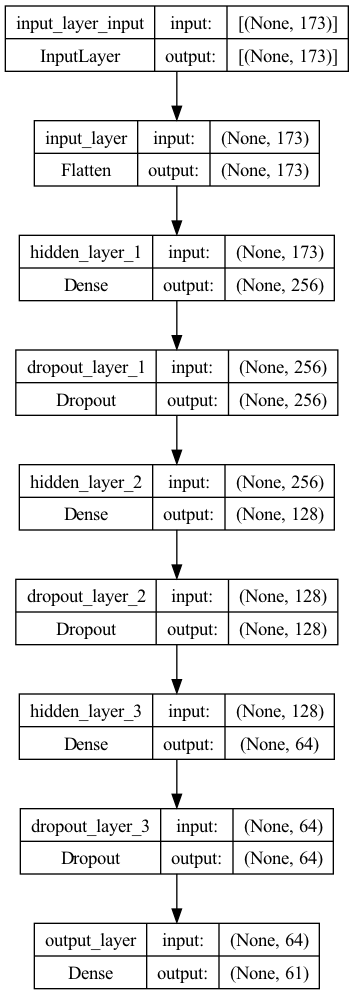

In [18]:
plot_model(model, to_file="chatKGEC.png", show_shapes=True)

## Training the model


In [19]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="../Models/chatKGEC",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
)
model_tensorboard_callback = TensorBoard(
    log_dir="../Logs/chatKGEC_logs", histogram_freq=1, write_images=True
)
model_csvlogger_callback = CSVLogger("../Logs/chatKGEC_logs.csv")

model_history = model.fit(
    train_X,
    train_y,
    batch_size=64,
    epochs=50,
    validation_split=0.1,
    callbacks=[
        model_checkpoint_callback,
        model_tensorboard_callback,
        model_csvlogger_callback,
    ],
)

Epoch 1/50


2023-08-12 11:10:53.486882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 4.0765 - categorical_accuracy: 0.0290

2023-08-12 11:10:53.937376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 1s 241ms/step - loss: 4.0765 - categorical_accuracy: 0.0290 - val_loss: 4.0198 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
1/4 [======>.......................] - ETA: 0s - loss: 3.6302 - categorical_accuracy: 0.1406INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 0s 140ms/step - loss: 3.4872 - categorical_accuracy: 0.1691 - val_loss: 3.7530 - val_categorical_accuracy: 0.0833
Epoch 3/50
1/4 [======>.......................] - ETA: 0s - loss: 2.9592 - categorical_accuracy: 0.2656INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 0s 143ms/step - loss: 2.7511 - categorical_accuracy: 0.2850 - val_loss: 3.4096 - val_categorical_accuracy: 0.0833
Epoch 4/50
1/4 [======>.......................] - ETA: 0s - loss: 2.2654 - categorical_accuracy: 0.3438INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 1s 164ms/step - loss: 2.1344 - categorical_accuracy: 0.3913 - val_loss: 2.9299 - val_categorical_accuracy: 0.2083
Epoch 5/50
1/4 [======>.......................] - ETA: 0s - loss: 1.6500 - categorical_accuracy: 0.5312INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 1s 218ms/step - loss: 1.6949 - categorical_accuracy: 0.5217 - val_loss: 2.6993 - val_categorical_accuracy: 0.4167
Epoch 6/50
4/4 [==============================] - 0s 41ms/step - loss: 1.1238 - categorical_accuracy: 0.6763 - val_loss: 2.8368 - val_categorical_accuracy: 0.3750
Epoch 7/50
1/4 [======>.......................] - ETA: 0s - loss: 0.8523 - categorical_accuracy: 0.6875INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 0s 142ms/step - loss: 0.8824 - categorical_accuracy: 0.7150 - val_loss: 2.6835 - val_categorical_accuracy: 0.5417
Epoch 8/50
1/4 [======>.......................] - ETA: 0s - loss: 0.4957 - categorical_accuracy: 0.8125INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 0s 137ms/step - loss: 0.6598 - categorical_accuracy: 0.7826 - val_loss: 2.4539 - val_categorical_accuracy: 0.4583
Epoch 9/50
4/4 [==============================] - 0s 41ms/step - loss: 0.5597 - categorical_accuracy: 0.8261 - val_loss: 2.4567 - val_categorical_accuracy: 0.4583
Epoch 10/50
1/4 [======>.......................] - ETA: 0s - loss: 0.5267 - categorical_accuracy: 0.8125INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 0s 137ms/step - loss: 0.4919 - categorical_accuracy: 0.8261 - val_loss: 2.4309 - val_categorical_accuracy: 0.5417
Epoch 11/50
4/4 [==============================] - 0s 40ms/step - loss: 0.4193 - categorical_accuracy: 0.8454 - val_loss: 2.5404 - val_categorical_accuracy: 0.5000
Epoch 12/50
4/4 [==============================] - 0s 40ms/step - loss: 0.4181 - categorical_accuracy: 0.8551 - val_loss: 2.7677 - val_categorical_accuracy: 0.5417
Epoch 13/50
4/4 [==============================] - 0s 40ms/step - loss: 0.3393 - categorical_accuracy: 0.9082 - val_loss: 2.7539 - val_categorical_accuracy: 0.5417
Epoch 14/50
4/4 [==============================] - 0s 40ms/step - loss: 0.2813 - categorical_accuracy: 0.9179 - val_loss: 2.8913 - val_categorical_accuracy: 0.5833
Epoch 15/50
4/4 [==============================] - 0s 42ms/step - loss: 0.3215 - categorical_accuracy: 0.9130 - val_loss: 2.8523 - val_categorical_accuracy: 0.7083
Epoch 16/50
4/4 [==========

INFO:tensorflow:Assets written to: ../Models/chatKGEC/assets


4/4 [==============================] - 0s 138ms/step - loss: 0.2644 - categorical_accuracy: 0.8986 - val_loss: 2.4006 - val_categorical_accuracy: 0.7083
Epoch 19/50
4/4 [==============================] - 0s 40ms/step - loss: 0.1478 - categorical_accuracy: 0.9565 - val_loss: 2.4105 - val_categorical_accuracy: 0.7500
Epoch 20/50
4/4 [==============================] - 0s 39ms/step - loss: 0.1887 - categorical_accuracy: 0.9324 - val_loss: 2.6569 - val_categorical_accuracy: 0.7083
Epoch 21/50
4/4 [==============================] - 0s 41ms/step - loss: 0.1349 - categorical_accuracy: 0.9517 - val_loss: 2.9270 - val_categorical_accuracy: 0.7083
Epoch 22/50
4/4 [==============================] - 0s 40ms/step - loss: 0.0889 - categorical_accuracy: 0.9758 - val_loss: 3.2826 - val_categorical_accuracy: 0.6667
Epoch 23/50
4/4 [==============================] - 0s 42ms/step - loss: 0.1219 - categorical_accuracy: 0.9420 - val_loss: 3.2780 - val_categorical_accuracy: 0.6667
Epoch 24/50
4/4 [==========

In [20]:
model_train_loss = model_history.history["loss"]
model_train_acc = model_history.history["categorical_accuracy"]
model_val_loss = model_history.history["val_loss"]
model_val_acc = model_history.history["val_categorical_accuracy"]

print("Training loss:", np.mean(model_train_loss))
print("Validation loss:", np.mean(model_val_loss))
print(
    "%f Training accuracy with a standard deviation of %f"
    % (np.mean(model_train_acc), np.std(model_train_acc))
)
print(
    "%f Validation accuracy with a standard deviation of %f"
    % (np.mean(model_val_acc), np.std(model_val_acc))
)

Training loss: 0.47698851838707923
Validation loss: 3.03813506603241
0.862126 Training accuracy with a standard deviation of 0.211480
0.627500 Validation accuracy with a standard deviation of 0.187900


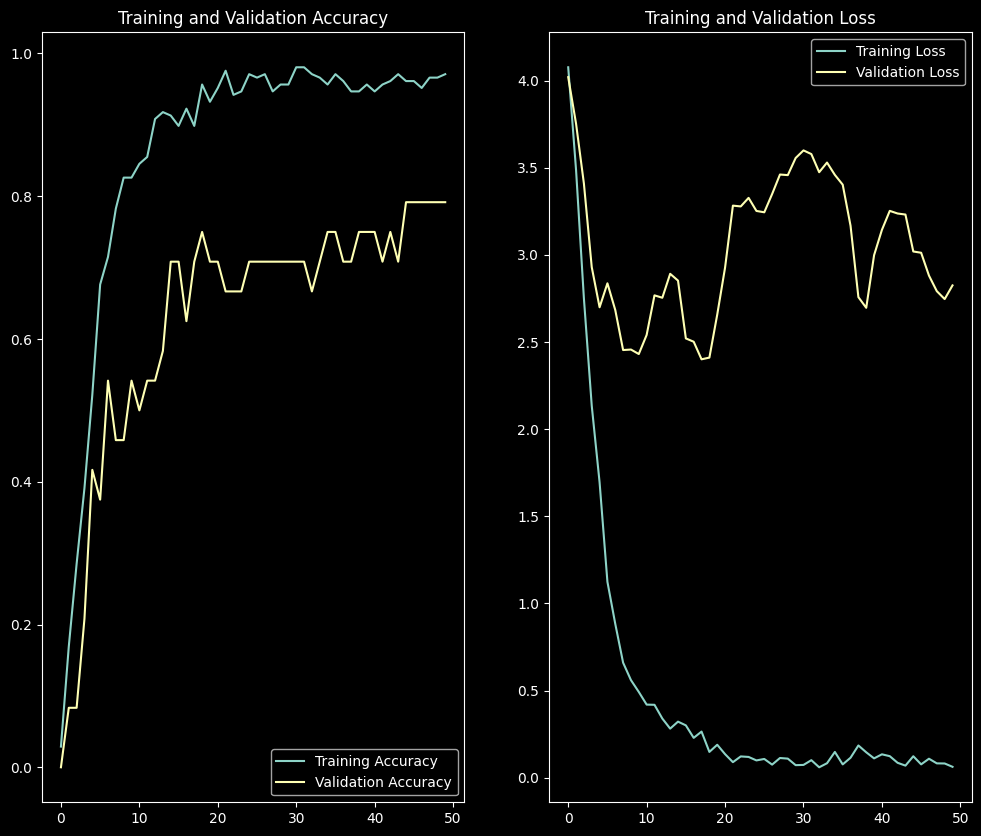

In [21]:
epochs_range = range(50)

# Plot the training and validation accuracy
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, model_train_acc, label="Training Accuracy")
plt.plot(epochs_range, model_val_acc, label="Validation Accuracy")
plt.legend(loc="best")
plt.title("Training and Validation Accuracy")

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, model_train_loss, label="Training Loss")
plt.plot(epochs_range, model_val_loss, label="Validation Loss")
plt.legend(loc="best")
plt.title("Training and Validation Loss")

plt.savefig("../Images/chatKGEC_acc_loss.png", bbox_inches="tight")

# Saving the model


In [22]:
model.save("chatKGEC.h5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
